# Introduction

This notebook backtests 500 stock tickers. After reading in the stock tickers from a CSV file, it calls `backtester()` to do all the hard work. This is basically a wrapper for the `backtester()`. The `backtester()` is stored in backtest.py.

In [1]:
from backtest import get_hist, smooth, features, stringify, print_ticker_heading, balanced_scorecard, \
                     determine_minima_n_maxima, align_minima_n_maxima, plot_trades, split_data, \
                     get_signals, merge_buy_n_sell_signals, extract_trades, get_possible_trades, \
                     backtester
import pandas as pd
import numpy as np

from   frankie     import DayForecast, optimize, baseline, cross_val_tpr
import yfinance as yf

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score, roc_auc_score
from sklearn.datasets import load_breast_cancer, load_iris, make_moons, make_circles, make_classification
from sklearn.linear_model import LogisticRegression
from category_encoders import WOEEncoder

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer, FunctionTransformer
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer

from datetime import date, timedelta

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.signal import savgol_filter, argrelmin, argrelmax

import gc; gc.enable()

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
# suppress output of plotting all the trades as this is quite a lot...
# plot_trades(tickers, min_indices, max_indices)

In [4]:
DATAPATH = '/Users/frkornet/Flatiron/Stock-Market-Final-Project/data/'
sdf = pd.read_csv(f'{DATAPATH}stocks_500.csv')
idx = (sdf.TICKER > '')
sdf = sdf.loc[idx].reset_index()
tickers = sdf.TICKER.to_list()

In [5]:
print(len(tickers), tickers)

483 ['ARAY', 'AYI', 'ADUS', 'IOTS', 'ADRO', 'AAP', 'WMS', 'ARPO', 'AES', 'AGCO', 'AGRX', 'ALRN', 'AIRT', 'AKRX', 'ALK', 'AA', 'AXU', 'ALXN', 'AQN', 'ALGN', 'ALLK', 'ABTX', 'AMRK', 'AEP', 'AFG', 'AMNB', 'AMT', 'AMWD', 'AMP', 'AMGN', 'FOLD', 'AMPH', 'PLAN', 'ATRS', 'ACRE', 'AGX', 'ARMP', 'ARWR', 'AIZ', 'ALOT', 'AAME', 'ATO', 'ATRC', 'ACB', 'ADP', 'AVB', 'AGR', 'AVY', 'AVA', 'BW', 'BTN', 'TBBK', 'BAC', 'BOCH', 'BPRN', 'BRN', 'BSET', 'BTE', 'BCBP', 'BASI', 'BPTH', 'BB', 'BKH', 'BMCH', 'BA', 'BOOT', 'BPFH', 'BXP', 'EPAY', 'BDGE', 'BCOV', 'BFAM', 'BHF', 'BRT', 'BLDR', 'BFST', 'CAMP', 'CPB', 'CNQ', 'CBNK', 'CCBG', 'COF', 'CFFN', 'CDLX', 'CSL', 'KMX', 'CARO', 'CASS', 'CBZ', 'CBL', 'CBMB', 'CM', 'CNP', 'CHRA', 'CTHR', 'CRL', 'CCF', 'CHEF', 'CHE', 'CHMI', 'CVX', 'CMRX', 'CAAS', 'CCRC', 'CXDC', 'CYD', 'CHD', 'CHUY', 'CINF', 'CTRN', 'CFG', 'CHCO', 'CLFD', 'CMS', 'JVA', 'COLM', 'CMCO', 'CBSH', 'COMM', 'JCS', 'CBU', 'TCFC', 'CRK', 'CAG', 'TCS', 'CORT', 'CPLG', 'COST', 'ICBK', 'CVIA', 'BREW', 'CRAI',

In [6]:
%time myPnL_df, my_Capital_df, possible_trades_df, buy_opportunities_df = backtester("backtest_0500.log", tickers, "10y", 10000, 5)

Simulating 457 stocks



local minima and maxima: 100%|██████████| 457/457 [03:19<00:00,  2.29it/s]



Unable to determine local minima and maxima for the following tickers:
['WCN']
Simulating with remaining 456 stocks



possible trades: 100%|██████████| 456/456 [09:45<00:00,  1.28s/it]



Possible trades to simulate: 4651
Trading days to simulate   : 741



simulate trades: 100%|██████████| 741/741 [03:00<00:00,  4.11it/s]


Today's buying recommendations:

    ticker   buy_date  buy_close  trading_days  gain_pct  daily_return
104   CBSH 2020-02-26      64.59     22.571429  2.910714      0.281429
289     PH 2020-02-26     189.65     15.352941  0.591765      0.263529
60    BPFH 2020-02-26      10.62      9.500000  1.058667      0.253000
229    KRC 2020-02-26      79.44     23.545455  3.129091      0.239091
351   SFST 2020-02-26      39.76     21.750000  3.106875      0.163750


Yesterday's buying recommendations:

    ticker   buy_date  buy_close  trading_days   gain_pct  daily_return
153   EXAS 2020-02-25      86.54     14.411765  10.054706      2.122941
392   PRTS 2020-02-25       2.38     19.842105   2.602105      1.104211
25    AMWD 2020-02-25      98.47     24.928571   2.857857      0.827143
2     ADUS 2020-02-25      93.62      6.842105   2.187895      0.690526
319     RF 2020-02-25      14.79     15.416667   1.987917      0.475833

CPU times: user 28min 50s, sys: 8.22 s, total: 28min 58s
Wall time: 

# Summary Chart

This chart provides an overview of well the backtest went and how it increased or decreased the initial capital over time.

In [7]:
idx = myPnL_df.action=='BUY'
first_buy_date = myPnL_df.loc[idx].date.min()
first_buy_date

Timestamp('2017-03-22 00:00:00')

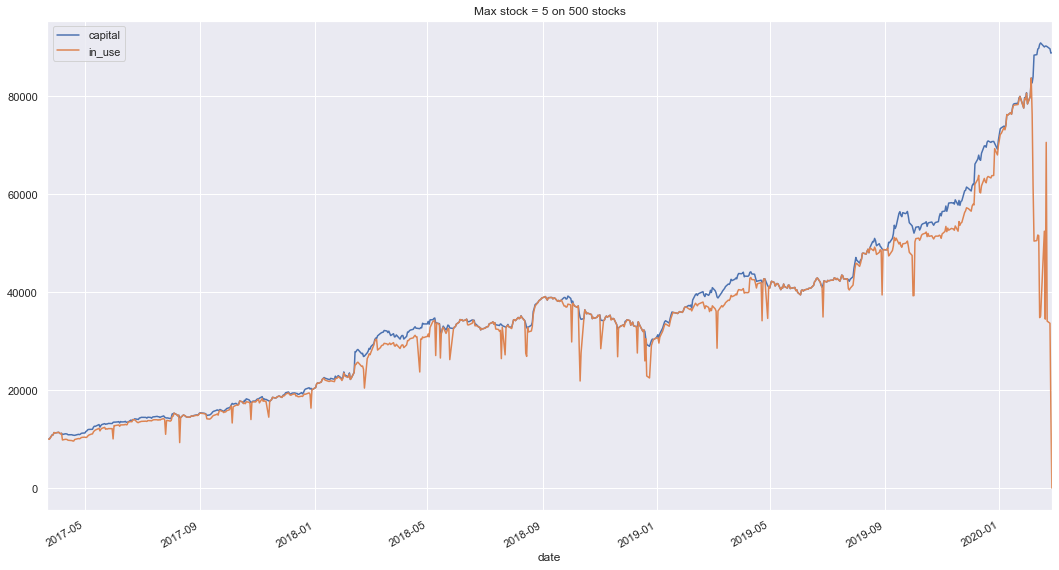

In [8]:
#myPnL_df, my_Capital_df = backtester()
myCapital_df = my_Capital_df
myCapital_df.index = myCapital_df.date
to_plot_cols = ['capital', 'in_use']
myCapital_df[to_plot_cols][first_buy_date:].plot(figsize=(18,10))
plt.title('Max stock = 5 on 500 stocks')
plt.show()

# Analysis of Results

The cells below perform a simple analysis. They look at the completed trades. For each trade it calculates the gain and gain percentage. With that it then displays the top ten losses and top ten gains. It ends with calculating the percentage of trades that resulted in a loss.

In [9]:
sell_df = myPnL_df[myPnL_df.action=='SELL'].copy()
sell_df['gain'] = (sell_df.close_amount - sell_df.orig_amount)
sell_df['gain_pct'] = round((sell_df.gain / sell_df.orig_amount)*100, 2)
sell_df['daily_comp_pct'] = (((1 + sell_df.gain_pct/100) ** (1/ sell_df.days_in_trade)) - 1)*100
sell_df

,date,ticker,action,orig_amount,close_amount,no_shares,stop_loss,daily_gain,daily_pct,days_in_trade,invested,gain,gain_pct,daily_comp_pct
0,2017-03-22,EPM,SELL,2000.000000,2000.000000,309.128567,5.82282,2.273737e-13,1.136868e-14,1,0,2.273737e-13,0.00,0.000000
0,2017-03-22,FSP,SELL,2000.000000,2000.000000,201.816347,8.91900,0.000000e+00,0.000000e+00,1,0,0.000000e+00,0.00,0.000000
0,2017-03-22,FCBC,SELL,2000.000000,2000.000000,93.808630,19.18800,2.273737e-13,1.136868e-14,1,0,2.273737e-13,0.00,0.000000
0,2017-03-22,DLA,SELL,2000.000000,2000.000000,123.685838,14.55300,0.000000e+00,0.000000e+00,1,0,0.000000e+00,0.00,0.000000
0,2017-03-22,JACK,SELL,2000.000000,2000.000000,21.213407,84.85200,2.273737e-13,1.136868e-14,1,0,2.273737e-13,0.00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2020-02-19,FFBC,SELL,18166.988347,18129.882570,742.115537,22.03200,-3.710578e+01,-2.042484e-01,2,0,-3.710578e+01,-0.20,-0.100050
0,2020-02-21,FCAP,SELL,17951.671669,18370.408932,270.153073,59.80500,1.458827e+02,8.004744e-01,7,0,4.187373e+02,2.33,0.329580
0,2020-02-21,HFWA,SELL,18038.093761,17991.049552,672.060125,24.15600,-4.704421e+01,-2.608048e-01,2,0,-4.704421e+01,-0.26,-0.130085
0,2020-02-25,CCBG,SELL,18038.093761,17123.918261,613.540604,26.46000,-3.006349e+02,-1.725352e+00,4,0,-9.141755e+02,-5.07,-1.292337


In [10]:
sell_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 529 entries, 0 to 0
Data columns (total 14 columns):
date              529 non-null datetime64[ns]
ticker            529 non-null object
action            529 non-null object
orig_amount       529 non-null float64
close_amount      529 non-null float64
no_shares         529 non-null float64
stop_loss         529 non-null float64
daily_gain        529 non-null float64
daily_pct         529 non-null float64
days_in_trade     529 non-null int64
invested          529 non-null int64
gain              529 non-null float64
gain_pct          529 non-null float64
daily_comp_pct    529 non-null float64
dtypes: datetime64[ns](1), float64(9), int64(2), object(2)
memory usage: 62.0+ KB


In [11]:
sell_df.describe()

,orig_amount,close_amount,no_shares,stop_loss,daily_gain,daily_pct,days_in_trade,invested,gain,gain_pct,daily_comp_pct
count,529.000000,529.000000,529.000000,529.000000,529.000000,529.000000,529.000000,529.0,529.000000,529.000000,529.000000
mean,6120.018923,6269.080323,886.379238,45.558953,16.264687,0.203356,7.841210,0.0,149.061400,2.394008,0.141742
std,3235.848996,3445.906796,2259.132025,70.339094,343.202717,5.058843,15.082894,0.0,838.359930,11.680767,1.136361
min,1836.144578,1816.816741,3.451739,0.279000,-1259.239019,-20.183486,1.000000,0.0,-1717.144117,-25.640000,-4.499411
25%,3443.608884,3454.035467,82.841404,7.038000,-43.373494,-0.720511,1.000000,0.0,-29.241136,-0.590000,-0.133512
50%,6299.251127,6254.164468,218.941328,22.356000,0.000000,0.000000,2.000000,0.0,0.000000,0.000000,0.000000
75%,7509.276622,7597.982414,713.209855,59.805000,33.945795,0.699588,7.000000,0.0,133.030997,2.330000,0.420869
max,18166.988347,23201.419919,32170.557591,968.526000,4291.560149,86.956522,159.000000,0.0,11918.150140,105.630000,8.508064


In [12]:
sell_df.sort_values(by='gain_pct', ascending=True)[0:10]

,date,ticker,action,orig_amount,close_amount,no_shares,stop_loss,daily_gain,daily_pct,days_in_trade,invested,gain,gain_pct,daily_comp_pct
0,2018-05-15,ENT,SELL,6696.862056,4979.717939,5723.813723,1.053,-1259.239019,-20.183486,12,0,-1717.144117,-25.64,-2.438542
0,2018-11-20,ROST,SELL,6670.984080,5630.928938,69.014940,86.994,-582.486092,-9.374653,5,0,-1040.055143,-15.59,-3.332880
0,2019-04-29,NOVN,SELL,7809.943903,6656.202190,8874.936253,0.792,-976.242988,-12.790698,4,0,-1153.741713,-14.77,-3.916653
0,2017-11-13,IMMR,SELL,3665.973946,3150.697959,536.745819,6.147,-193.228495,-5.778491,6,0,-515.275987,-14.06,-2.493727
0,2018-08-14,ENPH,SELL,6960.699929,5988.336395,1185.809187,5.283,-379.458940,-5.959032,6,0,-972.363533,-13.97,-2.476715
0,2019-10-01,ODT,SELL,9485.306207,8203.417612,334.696761,25.506,-508.739077,-5.839416,21,0,-1281.888595,-13.51,-0.688767
0,2017-05-31,ARWR,SELL,2401.356031,2083.104027,1446.600019,1.494,-86.796001,-4.000000,17,0,-318.252004,-13.25,-0.832631
0,2017-08-10,ISNS,SELL,2862.236072,2483.410709,841.834139,3.060,-126.275121,-4.838710,7,0,-378.825362,-13.24,-2.008477
0,2019-10-02,REKR,SELL,11238.649385,9772.738596,4886.369298,2.070,-586.364316,-5.660377,8,0,-1465.910789,-13.04,-1.731361
0,2018-08-15,ARAY,SELL,6678.311483,5810.130990,1669.577871,3.600,-250.436681,-4.132231,19,0,-868.180493,-13.00,-0.730279


In [13]:
sell_df.sort_values(by='gain_pct', ascending=False)[0:10]

,date,ticker,action,orig_amount,close_amount,no_shares,stop_loss,daily_gain,daily_pct,days_in_trade,invested,gain,gain_pct,daily_comp_pct
0,2020-02-05,ENPH,SELL,11283.269779,23201.419919,628.594417,16.155,6.285944,0.027100,64,0,11918.150140,105.63,1.132787
0,2018-03-09,ENPH,SELL,4423.253703,8823.707129,2280.027682,1.746,182.402215,2.110818,36,0,4400.453426,99.48,1.936692
0,2018-02-13,ZN,SELL,4049.164842,8060.837417,1874.613353,1.944,3749.226706,86.956522,31,0,4011.672575,99.07,2.245770
0,2017-04-07,SYX,SELL,1999.262161,3361.135791,395.893497,4.545,31.671480,0.951249,11,0,1361.873630,68.12,4.836099
0,2019-09-05,MEDP,SELL,7959.485599,12621.971317,152.568250,46.953,204.441455,1.646394,128,0,4662.485718,58.58,0.360875
0,2018-09-24,EXAS,SELL,6221.459528,9488.237909,120.500862,46.467,296.432122,3.224961,37,0,3266.778381,52.51,1.147233
0,2019-09-16,KOD,SELL,9810.151534,14910.411976,848.629025,10.404,2189.462886,17.211474,20,0,5100.260443,51.99,2.115284
0,2017-06-26,NVDA,SELL,2155.949332,3242.950102,21.490723,90.288,-35.674600,-1.088096,47,0,1087.000770,50.42,0.872424
0,2019-02-04,ENPH,SELL,5784.394533,8114.381108,1159.197301,4.491,0.000000,0.000000,27,0,2329.986575,40.28,1.261484
0,2019-02-26,NEWR,SELL,6654.976438,9042.711706,85.704783,69.885,-28.282579,-0.311791,61,0,2387.735268,35.88,0.503891


In [14]:
sell_df[sell_df.gain_pct < 0].count()[0], sell_df[sell_df.gain_pct < 0].count()[0]/len(sell_df)

(151, 0.28544423440453687)

In [15]:
myPnL_df

,date,ticker,action,orig_amount,close_amount,no_shares,stop_loss,daily_gain,daily_pct,days_in_trade,invested
0,2017-03-22,FCBC,BUY,2000.000000,2000.000000,93.808630,19.18800,0.000000,0.000000,0,0
0,2017-03-22,ICFI,BUY,2000.000000,2000.000000,49.164208,36.61200,0.000000,0.000000,0,0
0,2017-03-22,EPM,BUY,2000.000000,2000.000000,309.128567,5.82282,0.000000,0.000000,0,0
0,2017-03-22,DLA,BUY,2000.000000,2000.000000,123.685838,14.55300,0.000000,0.000000,0,0
0,2017-03-22,FSP,BUY,2000.000000,2000.000000,201.816347,8.91900,0.000000,0.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...
0,2020-02-24,NXRT,CLOSE,13959.882596,16199.246962,321.286136,39.10500,61.044366,0.378260,45,0
0,2020-02-24,CCBG,CLOSE,18038.093761,17424.553157,613.540604,26.46000,-496.967889,-2.773023,3,0
0,2020-02-25,CCBG,SELL,18038.093761,17123.918261,613.540604,26.46000,-300.634896,-1.725352,4,0
0,2020-02-25,NXRT,CLOSE,13959.882596,15614.506195,321.286136,39.10500,-584.740767,-3.609679,46,0


In [16]:
sell_df.ticker.unique(), len(sell_df.ticker.unique())

(array(['EPM', 'FSP', 'FCBC', 'DLA', 'JACK', 'CBSH', 'CCBG', 'ICFI',
        'LANC', 'LUNA', 'CFR', 'TDG', 'AMP', 'AMGN', 'GCO', 'BTE', 'CVI',
        'EXAS', 'HOFT', 'ARWR', 'IMMR', 'JCS', 'SYX', 'ISSC', 'CMS', 'MBI',
        'ROST', 'ARAY', 'ZN', 'WOR', 'GFN', 'CORT', 'ISNS', 'BASI', 'FOLD',
        'MSEX', 'VSH', 'TNAV', 'MNTA', 'RNST', 'PEG', 'CREE', 'NWFL',
        'FCAP', 'KRA', 'ADUS', 'MTSC', 'STRL', 'DPZ', 'FICO', 'EPAY',
        'XRAY', 'GMO', 'FLNT', 'COST', 'LAWS', 'NSYS', 'NVDA', 'ETR',
        'ITT', 'POWL', 'RF', 'DSGX', 'HWC', 'AMWD', 'NAV', 'NSIT', 'BREW',
        'WEC', 'AES', 'CRK', 'KRC', 'CTHR', 'JBSS', 'AMT', 'ATRS', 'VIAV',
        'CRL', 'TRNS', 'NOA', 'IMAX', 'WAT', 'ALOT', 'EDSA', 'CTRN',
        'PCTI', 'ENT', 'YUM', 'IDXX', 'RGEN', 'KIRK', 'PRTS', 'WINA',
        'DRI', 'USIO', 'TR', 'FISV', 'TRIP', 'MDP', 'KMX', 'PFIS', 'AXU',
        'SLG', 'WMS', 'IAG', 'COF', 'BAC', 'MKL', 'ADP', 'EBF', 'SYNA',
        'ENV', 'AVY', 'ROK', 'CHEF', 'PRSC', 'HLIT', 'HTBI',

In [17]:
sell_df[['ticker', 'gain']].groupby(by='ticker').sum().reset_index().sort_values(by='gain', ascending=False)[0:10]

,ticker,gain
67,ENPH,17676.226608
73,EXAS,6842.454658
121,KOD,5416.508011
189,SYX,4888.725041
131,MEDP,4662.485718
148,NXRT,4660.305971
193,TNAV,4474.035968
88,GCO,4262.506682
146,NVDA,2644.290359
138,NEWR,2387.735268


In [18]:
sell_df[['ticker', 'gain']].groupby(by='ticker').sum().reset_index().sort_values(by='gain', ascending=True)[0:10]

,ticker,gain
170,REKR,-1465.910789
149,ODT,-1281.888595
141,NOVN,-1153.741713
9,AGRX,-1120.649986
40,CCBG,-914.175500
188,SYNC,-802.250580
108,IQV,-770.719542
186,SYF,-754.386550
155,PCTY,-730.544680
127,LUNA,-729.577411


In [19]:
sell_df[['ticker', 'gain']].groupby(by='ticker').mean().reset_index().sort_values(by='gain', ascending=False)[0:10]

,ticker,gain
131,MEDP,4662.485718
67,ENPH,4419.056652
138,NEWR,2387.735268
148,NXRT,2330.152986
193,TNAV,2237.017984
93,GWRS,1977.004427
121,KOD,1805.502670
32,BPRN,1200.602911
208,WING,1128.332348
140,NOA,751.144900


In [20]:
sell_df[['ticker', 'gain']].groupby(by='ticker').mean().reset_index().sort_values(by='gain', ascending=True)[0:10]

,ticker,gain
170,REKR,-1465.910789
149,ODT,-1281.888595
141,NOVN,-1153.741713
155,PCTY,-730.544680
9,AGRX,-560.324993
40,CCBG,-457.087750
127,LUNA,-364.788705
169,RCL,-291.270501
188,SYNC,-267.416860
186,SYF,-251.462183


In [21]:
myCapital_df.tail()

,date,capital,in_use,free
date,,,,
2020-02-20,2020-02-20,90182.9,70538.5,19644.4
2020-02-21,2020-02-21,90065.5,34059.7,56005.8
2020-02-24,2020-02-24,89629.6,33623.8,56005.8
2020-02-25,2020-02-25,88744.2,15614.5,73129.7
2020-02-26,2020-02-26,88853.5,1.00044e-10,88853.5


In [22]:
len(possible_trades_df)

4651

In [23]:
possible_trades_df.to_csv(f'{DATAPATH}possible_trades_0500.csv', index=False)
myCapital_df.to_csv(f'{DATAPATH}capital_0500.csv', index=False)
myPnL_df.to_csv(f'{DATAPATH}PnL_0500.csv', index=False)

In [24]:
ls ../data

F13_Renaissance_tech.csv  capital_0500.csv          possible_trades_1000.csv
F13_Renaissance_tech.txt  capital_1000.csv          possible_trades_1500.csv
PnL_0100.csv              capital_1500.csv          possible_trades_2000.csv
PnL_0500.csv              capital_2000.csv          stocks.csv
PnL_1000.csv              exclude.csv               stocks_100.csv
PnL_1500.csv              optimal_params.csv        stocks_1000.csv
PnL_2000.csv              possible_trades_0100.csv  stocks_2000.csv
capital_0100.csv          possible_trades_0500.csv  stocks_500.csv
